In [1]:
# financial data
import yfinance as yf

# data manipulation
import pandas as pd

# time series forecasting
from prophet import Prophet

# plotting
import matplotlib.pyplot as plt

In [2]:
# Download historical stock prices for a company
tesla = yf.download('TSLA', start="2010-01-01", end="2023-01-01")
gm = yf.download('GM', start="2010-01-01", end="2023-01-01")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


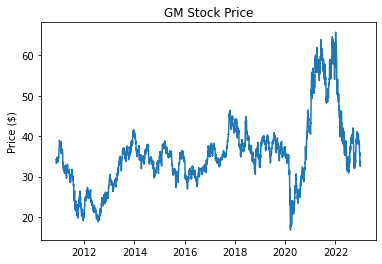

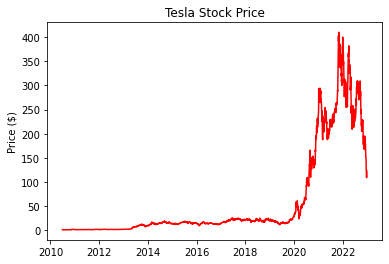

In [3]:
# Plot the historical stock prices

plt.plot(gm.index, gm['Close'])
plt.title('GM Stock Price')
plt.ylabel('Price ($)')

# Save the figure.
plt.savefig("./Images/GMStockPrice.jpg")

plt.show()

plt.plot(tesla.index, tesla['Close'], 'r')
plt.title('Tesla Stock Price')
plt.ylabel('Price ($)')

# Save the figure.
plt.savefig("./Images/TSLAStockPrice.jpg")

plt.show()

In [4]:
# Prepare the data for prophet
# TSLA
tesla = tesla[["Close"]].copy()
tesla.reset_index(inplace=True)
tesla.rename(columns={"Date": "ds", "Close": "y"}, inplace=True)

# GM
gm = gm[["Close"]].copy()
gm.reset_index(inplace=True)
gm.rename(columns={"Date": "ds", "Close": "y"}, inplace=True)

In [5]:
# Split the data into training and testing sets
split_date = "2019-01-01"

# TSLA
tesla_train_data = tesla.query("ds < @split_date")
tesla_test_data = tesla.query("ds >= @split_date")

# GM
gm_train_data = gm.query("ds < @split_date")
gm_test_data = gm.query("ds >= @split_date")

In [6]:
# Create and fit the prophet model

# TSLA
tesla_model = Prophet(daily_seasonality=True, changepoint_prior_scale=0.05)
tesla_model.fit(tesla_train_data)

# GM
gm_model = Prophet(daily_seasonality=True, changepoint_prior_scale=0.05)
gm_model.fit(gm_train_data)

In [7]:
# Create a forecast for the next 2 years

# TSLA
tesla_future_data = tesla_model.make_future_dataframe(periods=365*2, freq='D')
tesla_forecast = tesla_model.predict(tesla_future_data)

# GM
gm_future_data = gm_model.make_future_dataframe(periods=365*2, freq='D')
gm_forecast = gm_model.predict(gm_future_data)

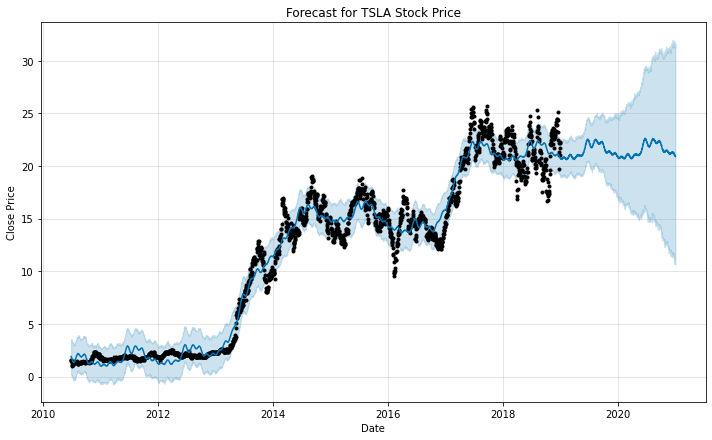

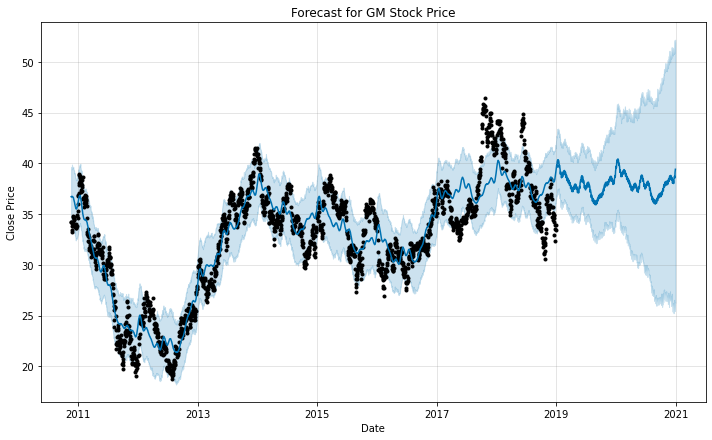

In [8]:
# Plot the forecast
# TSLA
tesla_model.plot(tesla_forecast)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Forecast for TSLA Stock Price")

# Save the figure.
plt.savefig("./Images/ForecastTSLA.jpg")

plt.show()

# GM
gm_model.plot(gm_forecast)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Forecast for GM Stock Price")

# Save the figure.
plt.savefig("./Images/ForecastGM.jpg")

plt.show()

## Effect of Changepoint Prior Scale

In [ ]:
# Try 4 different changepoints

# TSLA
for changepoint in [0.001, 0.05, 0.1, 0.5]:
    tesla_model = Prophet(daily_seasonality=True, changepoint_prior_scale=changepoint)
    tesla_model.fit(tesla_train_data)
    
    tesla_future_data = tesla_model.make_future_dataframe(periods=365*2, freq='D')
    tesla_forecast = tesla_model.predict(tesla_future_data)
    tesla[changepoint] = tesla_forecast['yhat']
    

In [ ]:
# Create the plot
plt.figure(figsize=(10, 8))

# Actual observations
plt.plot(tesla['ds'], tesla['y'], 'ko', label = 'Observations')
colors = {0.001: 'b', 0.05: 'r', 0.1: 'grey', 0.5: 'gold'}

# Plot each of the changepoint predictions
for changepoint in [0.001, 0.05, 0.1, 0.5]:
    plt.plot(tesla['ds'], tesla[changepoint], color = colors[changepoint], label = '%.3f prior scale' % changepoint)
    
plt.legend(prop={'size': 14})
plt.xlabel('Date'); plt.ylabel('Market Cap (billions $)'); plt.title('Effect of Changepoint Prior Scale');

# Save the figure.
plt.savefig("./Images/TSLAChangepointPriorScale.jpg")

In [ ]:
# Try 4 different changepoints

# GM
for changepoint in [0.001, 0.05, 0.1, 0.5]:
    gm_model = Prophet(daily_seasonality=True, changepoint_prior_scale=changepoint)
    gm_model.fit(gm_train_data)
    
    gm_future_data = gm_model.make_future_dataframe(periods=365*2, freq='D')
    gm_forecast = gm_model.predict(gm_future_data)
    gm[changepoint] = gm_forecast['yhat']
    

In [ ]:
# Create the plot
plt.figure(figsize=(10, 8))

# Actual observations
plt.plot(gm['ds'], gm['y'], 'ko', label = 'Observations')
colors = {0.001: 'b', 0.05: 'r', 0.1: 'grey', 0.5: 'gold'}

# Plot each of the changepoint predictions
for changepoint in [0.001, 0.05, 0.1, 0.5]:
    plt.plot(gm['ds'], gm[changepoint], color = colors[changepoint], label = '%.3f prior scale' % changepoint)
    
plt.legend(prop={'size': 14})
plt.xlabel('Date'); plt.ylabel('Market Cap (billions $)'); plt.title('Effect of Changepoint Prior Scale');

# Save the figure.
plt.savefig("./Images/GMChangepointPriorScale.jpg")

In [ ]:
tesla_model.changepoints[:10]

In [ ]:
gm_model.changepoints[:10]

## Compare Forecasts

We want to determine when Tesla will overtake GM in total market value. We already have the forecasts for two years into the future. We will now join them together and determine when the model predicts Tesla will pull ahead.

In [ ]:
gm_names = ['gm_%s' % column for column in gm_forecast.columns]
tesla_names = ['tesla_%s' % column for column in tesla_forecast.columns]

# Dataframes to merge
merge_gm_forecast = gm_forecast.copy()
merge_tesla_forecast = tesla_forecast.copy()

# Rename the columns
merge_gm_forecast.columns = gm_names
merge_tesla_forecast.columns = tesla_names

In [ ]:
# Merge the two datasets
forecast = pd.merge(merge_gm_forecast, merge_tesla_forecast, how = 'inner', left_on = 'gm_ds', right_on = 'tesla_ds')

# Rename date column
forecast = forecast.rename(columns={'gm_ds': 'Date'}).drop('tesla_ds', axis=1)
forecast.head()

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(forecast['Date'], forecast['gm_trend'], 'b-')
plt.plot(forecast['Date'], forecast['tesla_trend'], 'r-')
# plt.legend(); plt.xlabel('Date'); plt.ylabel('Market Cap ($)')
plt.title('GM vs. Tesla Trend'); 

# Save the figure.
plt.savefig("./Images/GMvsTSLATrend.jpg")

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(forecast['Date'], forecast['gm_yhat'], 'b-')
plt.plot(forecast['Date'], forecast['tesla_yhat'], 'r-')
# plt.legend(); plt.xlabel('Date'); plt.ylabel('Market Cap (billions $)')
plt.title('GM vs. Tesla Estimate'); 

# Save the figure.
plt.savefig("./Images/GMvsTSLAEstimate.jpg")

In [ ]:
# # Check if there are any rows where Tesla's stock price predictions are higher than GM's
# overtake_date = forecast[forecast['tesla_yhat'] > forecast['gm_yhat'], 'Date']

# if overtake_date.empty:
#     print("Tesla's stock price predictions are never higher than GM's")
# else:
#     min_overtake_date = min(overtake_date)
#     print('Tesla overtakes GM on {}'.format(min_overtake_date))

## Forecast with Uncertainty Bounds

In [ ]:
# Only keep years 2011 onwards and from before 2020
forecast = forecast[forecast['Date'] > '2010-12-31']
forecast = forecast[forecast['Date'] < '2020-01-01']

In [ ]:
# Create subplots to set figure size
fig, ax = plt.subplots(1, 1, figsize=(10, 8));

# Plot estimate
ax.plot(forecast['Date'], forecast['gm_yhat'], label = 'gm prediction');

# Plot uncertainty values
ax.fill_between(forecast['Date'].dt.to_pydatetime(), forecast['gm_yhat_upper'], forecast['gm_yhat_lower'], alpha=0.6, edgecolor = 'k');

# Plot estimate and uncertainty for tesla
ax.plot(forecast['Date'], forecast['tesla_yhat'], 'r', label = 'tesla prediction');
ax.fill_between(forecast['Date'].dt.to_pydatetime(), forecast['tesla_yhat_upper'], forecast['tesla_yhat_lower'], alpha=0.6, edgecolor = 'k');
plt.legend();
plt.xlabel('Date'); plt.ylabel('Billions $'); plt.title('Market Cap Prediction for GM and Tesla');

# Save the figure.
plt.savefig("./Images/MarketcapPreiction.jpg")

### Trends and Patterns
Now, we can use the Prophet Models to inspect different trends in the data.

In [ ]:
gm_model.plot_components(gm_forecast);

# Save the figure.
plt.savefig("./Images/GMProphetTrends.jpg")

In [ ]:
tesla_model.plot_components(tesla_forecast)

# Save the figure.
plt.savefig("./Images/TSLAProphetTrends.jpg")


These graphs show that Tesla tends to increase during the summer, and decrease during the winter, while GM plummets during the summer and increases during the winter. We could compare GM sales with these graphs to see if there is any correlation.